# Hubbard Model: A Tunable Model of Electron Correlation
**Evangeslista Group Rotation Project**

Brian Zhao, 10 Oct 2022

We first consider the simplest case, an open, one-dimensional Hubbard model. For an $N$-site $1$-D Hubbard model, we represent a configuration as
$$
|\mathbf{\text{n}}\rangle = |\underbrace{k_{1\uparrow}k_{2\uparrow}k_{3\uparrow}\dots k_{N\uparrow}}_{\text{alpha}}\underbrace{k_{1\downarrow}k_{2\downarrow}k_{3\downarrow}\dots k_{N\downarrow}}_{\text{beta}}\rangle
$$
where $k_i$ is the occupatation number of the $i$-th spinorbital.

In [7]:
import numpy as np
import scipy.special
from IPython.display import display, Math
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib widget

def get_excitation_level(f1, f2):
    """
    Get the excitation level between two bit strings f1 and f2, i.e., half the Hamming distance.
    """
    return int(count_set_bits(f1^f2)/2)    

def count_set_bits(f):
    """
    Return the number of set (1) bits in the bit string f.
    """
    return int(bin(f).count('1'))

def bstring_dot(f1, f2):
    if get_excitation_level(f1,f2) == 0:
        return 1
    else:
        return 0

def set_bit(f, bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    return f | 1<<bit_loc

def clear_bit(f, bit_loc):
    """
    Unset the bit_loc-th bit in bit string f. Returns unchanged if the bit is already unset. bit_loc is zero-indexed.
    """
    return f & ~(1<<bit_loc)

def test_bit(f, bit_loc):
    """
    Test if bit_loc in f is set. Returns 1 if set, 0 if not set.
    """
    return (f & (1<<bit_loc)) >> bit_loc

def next_comb(n, k, comb):
    """
    Generate systematically the next combination of k objects in n bins. 
    comb is incremented like this:
    [0,1,2,...,k-1,k]
    [0,1,2,...,k-1,k+1]
    ...
    [0,1,2,...,k-1,n]
    [0,1,2,...,k,k+1]
    [0,1,2,...,k,k+2]
    ...
    """
    i = k-1
    comb[i] += 1
    
    while (comb[i] >= n - k + 1 + i):
        i -= 1
        if (i < 0):
            break
        comb[i] += 1
    
    if (comb[0] > n-k):
        ierr = 1
    else:
        ierr = 0
        for j in range(i+1, k):
            comb[j] = comb[j-1] + 1
            
    return ierr, comb

def occ_list_to_bit_string(occ_list):
    """
    Occupation list to bitstring.
    occ_list is of length n_el, the i-th element is the index of spinorbital occupied by the i-th electron.
    """
    bstring = 0
    for i in range(len(occ_list)):
        bstring = set_bit(bstring, occ_list[i])
    return bstring

class HubbardLattice:
    """
    The Hubbard lattice with open or periodic boundary conditions in one or two dimensions.
    """
    def __init__(self, nsites, nalpha, nbeta, t, u, pbc=False, verbose=False):
        if type(nsites) is int:
            self.nsites = nsites
            self.xdim = self.ydim = None
            self.ndim = 1
        elif type(nsites) is tuple:
            self.xdim, self.ydim = nsites
            self.nsites = self.xdim * self.ydim
            self.ndim = 2
        else:
            raise TypeError('nsites can only be int or tuple!')
            
        self.bit_string_length = self.nsites*2
        self.nalpha = nalpha
        self.nbeta = nbeta
        self.nel = self.nalpha + self.nbeta
        self.t = t
        self.u = u
        self.ms = (nalpha-nbeta)/2.0
        self.pbc = pbc
        self.verbose = verbose
        
        self.alpha_mask = 0
        self.beta_mask = 0
        for i in range(self.nsites):
            self.alpha_mask = set_bit(self.alpha_mask, i)
            self.beta_mask = set_bit(self.beta_mask, i+self.nsites)
        
        self.nalpha_combinations = None
        self.nbeta_combinations = None
        self.ncomb = None
        self.mem_reqd_list = None
        self.mem_reqd_hamil = None
        self.alpha_strings = None
        self.beta_strings = None
        self.tot_strings = None
        self.hamil = None
        self.eigvals = None
        self.eigvecs = None
        self.occ_mat = None
        self.state_labels = None
        self.sites = None
        self.connections = None
        
        if (self.ndim == 2):
            self.site_enumeration_rect()
            self.generate_connections()
        
        # Unlikely do be doing more than 32 sites for now..
        #self.bit_string_len = int(np.ceil(self.nsites*2/64))
        
    def creop(self, bit_string, spinorb):
        """
        Creation operator, creates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already occupied, sign is zero and the bit string is returned unchanged.
        """
        # If the bit is set then sgn = 0
        if (test_bit(bit_string, spinorb)):
            sgn = 0
        else:
            test_string = 0
            
            # if we have a beta creation operator, we need to 'hide' the alpha string
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = set_bit(bit_string, spinorb)
            if (spinorb >= self.nsites):
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = set_bit(bit_string, spinorb)

        return (sgn, bit_string)

    def annop(self, bit_string, spinorb):
        """
        Annihilation operator, annihilates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already empty, sign is zero and the bit string is returned unchanged.
        """
        if (not test_bit(bit_string, spinorb)):
            sgn = 0
        else:
            test_string = 0
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = clear_bit(bit_string, spinorb)
            # if we have a beta annihilation operator, we need to 'hide' the alpha string
            else:
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = clear_bit(bit_string, spinorb)
        return (sgn, bit_string)


    def enumerate_states(self):
        """
        Enumerates all states of hl, only conserving Ms symmetry.
        """
        self.nalpha_combinations = int(scipy.special.binom(self.nsites, self.nalpha))
        self.nbeta_combinations = int(scipy.special.binom(self.nsites, self.nbeta))
        self.ncomb = self.nalpha_combinations * self.nbeta_combinations
        self.mem_reqd_list = self.ncomb*8/1e3 # We use 64-bit integers
        self.mem_reqd_hamil = (self.ncomb**2)*8/1e3

        if self.verbose:
            print(f"""There are {self.nalpha_combinations:d} alpha combinations,
{self.nbeta_combinations:d} beta combinations,
making a total of {self.ncomb:d} combinations,
requiring a memory of {self.mem_reqd_list:.2f} kB for the list of states,
and a memory of {self.mem_reqd_hamil:.2f} kB for the Hamiltonian, if requested.""")
        
        self.alpha_strings = np.zeros(self.nalpha_combinations, dtype='int64')
        self.beta_strings = np.zeros(self.nbeta_combinations, dtype='int64')
        self.tot_strings = np.zeros(self.ncomb, dtype='int64')

        comb = list(range(self.nalpha))
        self.alpha_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nalpha_combinations):
            ierr, comb = next_comb(self.nsites, self.nalpha, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.alpha_strings[i] = occ_list_to_bit_string(comb)

        comb = list(range(self.nbeta))
        self.beta_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nbeta_combinations):
            ierr, comb = next_comb(self.nsites, self.nbeta, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.beta_strings[i] = occ_list_to_bit_string(comb)

        istring = 0
        for ialpha in range(self.nalpha_combinations):
            for ibeta in range(self.nbeta_combinations):
                self.tot_strings[istring] = ((self.beta_strings[ibeta])<<self.nsites) | (self.alpha_strings[ialpha])
                istring += 1
        
        self.get_occ_mat()
                
    def bit_string_to_occ_vec(self, bstring):
        ov_alpha = np.zeros(self.nsites, dtype='int32')
        ov_beta = np.zeros(self.nsites, dtype='int32')

        for i in range(self.nsites):
            ov_alpha[i] += (bstring>>i) & 1
            ov_beta[i] += (bstring>>(i+self.nsites)) & 1

        return ov_alpha, ov_beta, (ov_alpha+ov_beta)


    def generate_pretty_state_labels(self):
        if (self.ndim == 1):
            self.state_labels = []
            for bstring in self.tot_strings:
                ov_alpha,ov_beta,_ = self.bit_string_to_occ_vec(bstring)
                string = '|'
                for i in range(self.nsites):
                    if ov_alpha[i] == 0 and ov_beta[i] == 0:
                        string += '--'
                    elif ov_alpha[i] == 1 and ov_beta[i] == 0:
                        string += '↑-'
                    elif ov_alpha[i] == 0 and ov_beta[i] == 1:
                        string += '-↓'
                    elif ov_alpha[i] == 1 and ov_beta[i] == 1:
                        string += '⇅'

                    if i != self.nsites-1:
                        string += ','
                    else:
                        string += '>'
                self.state_labels.append(string)
        
    def get_excitation_connection(self, f1, f2):
        """
        Get the bit location(s) of the set bits, given the number of set bits
        """
        excit_bstring = f1^f2 # 2 bits will be set if single excitation, which is the only type supported for now
        excit = [0,0] # excited from in f1, excited to in f2
        nbit_found = 0
        for i in range(self.bit_string_length):
            if (test_bit(excit_bstring, i)):
                # Check where this electron is coming from / going to
                if (test_bit(f1, i)):
                    excit[0] = i
                else:
                    excit[1] = i
                nbit_found += 1
                if (nbit_found == 2):
                    break
        return excit
                
    def pretty_print_states(self):
        if (self.ndim == 1):
            print(f'There are {self.ncomb:d} states with {self.nalpha:d} alpha electrons and {self.nbeta:d} beta electrons in {self.nsites:d} sites.')
            self.generate_pretty_state_labels()
            for i in range(len(self.tot_strings)):
                print(f'{i:<5d}{self.state_labels[i]}')
            
    def get_hmatel(self, f1, f2):
        """
        <f1|H|f2>
        """
        hmatel = 0.0
        exlvl = get_excitation_level(f1, f2)
        if (exlvl > 1):
            hmatel = 0.0
        else:
            if (exlvl == 0):
                # Diagonal element
                beta_bstring = (f1 >> self.nsites)
                hmatel += self.u * count_set_bits(beta_bstring & f1)
                if (self.pbc):
                    # Possible kinetic contribution
                    if self.ndim == 1 and self.nsites == 1:
                        hmatel -= 2*self.t*self.nel
                    if self.ndim == 2:
                        if self.xdim == 1 and self.ydim == 1:
                            hmatel -= 4*self.t*self.nel
                        elif self.xdim == 1 or self.ydim == 1:
                            hmatel -= 2*self.t*self.nel
            if (exlvl == 1):
                # Off-diagonal element
                excit = self.get_excitation_connection(f1, f2)
                if (self.ndim == 1):
                    if (abs(excit[0]-excit[1]) == 1):
                        sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                        hmatel -= sgn*self.t
                    if (self.pbc and abs(excit[0]-excit[1]) == self.nsites-1):
                        sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                        hmatel -= sgn*self.t
                else:
                    if (self.connections[excit[0]%self.nsites,excit[1]%self.nsites] != 0):
                        sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                        hmatel -= sgn*self.t*self.connections[excit[0]%self.nsites,excit[1]%self.nsites]
                        
        
        return hmatel
    
    def get_hamil(self):
        self.hamil = np.zeros((self.ncomb, self.ncomb))
        
        for i in range(self.ncomb):
            for j in range(i+1):
                self.hamil[i,j] = self.hamil[j,i] = self.get_hmatel(self.tot_strings[i],self.tot_strings[j])
                
    def solve_model(self):
        """
        Just a convenient wrapper
        """
        self.enumerate_states()
        self.get_hamil()
        self.eigvals, self.eigvecs = np.linalg.eigh(self.hamil)
        
    def plot_eigvecs(self):
        if (self.state_labels is None):
            self.generate_pretty_state_labels()
        f,ax = plt.subplots(figsize=(12,12))
        im = ax.imshow((self.eigvecs)**2)
        ax.set_yticks(list(range(self.ncomb)))
        ax.set_yticklabels(self.state_labels)
        f.colorbar(im,fraction=0.0455, pad=0.04, label=r'$|c_i|^2$')
        ax.set_title(r'${nsite}$-site, ${nel}$e, $M_s={ms}$ Hubbard model, $U/t={ut:.1f}$'.format(nsite=self.nsites, nel=self.nel, ms=self.ms, ut=float(self.u/self.t)))
        ax.set_xlabel('Eigenstate index')
        ax.set_ylabel('Many-body basis state')
        
    def get_occ_mat(self):
        # This is essentially doing <psi|n_i|psi>
        self.occ_mat = np.zeros((self.ncomb,self.bit_string_length))
        for i in range(self.ncomb):
            oa, ob, _ = self.bit_string_to_occ_vec(self.tot_strings[i])
            self.occ_mat[i,::2] = oa
            self.occ_mat[i,1::2] = ob
            
    def plot_states(self):
        f,ax = plt.subplots(figsize=(8,8))
        ax.plot(np.arange(self.ncomb),self.eigvals,marker='x')
        ax.set_xlabel('Eigenstate index')
        ax.set_ylabel(r'$E$')
        
    def get_rdm_element(self, i_eigst, i, j):
        rdm_el = 0.0
        for abasis, ca in enumerate(self.eigvecs[:,i_eigst]):
            for bbasis, cb in enumerate(self.eigvecs[:,i_eigst]):
                # ca*cb * <abasis|a_i^ a_j|bbasis>
                isgn,istr = self.annop(self.tot_strings[abasis],i)
                jsgn,jstr = self.annop(self.tot_strings[bbasis],j)
                rdm_el += ca*cb * isgn * jsgn * bstring_dot(istr,jstr)

        return rdm_el

    def get_rdm(self, i_eigst):
        rdm = np.zeros((self.bit_string_length,self.bit_string_length))
        for i in range(self.bit_string_length):
            for j in range(i+1):
                rdm[i,j] = rdm[j,i] = self.get_rdm_element(i_eigst, i, j)

        return rdm
    
    def plot_rdm(self, i_eigst):
        rdm = self.get_rdm(i_eigst)
        f,ax = plt.subplots(figsize=(8,8))
        im = ax.imshow(rdm,vmin=-1,vmax=1,cmap='Spectral')
        f.colorbar(im, fraction=0.0455, pad=0.04)
        ax.set_title(r"""1-RDM for eigenstate {i_eigst} of the ${nsite}$-site, 
${nel}$e, $M_s={ms}$ Hubbard model, $U/t={ut:.1f}$""".format(i_eigst=i_eigst, nsite=self.nsites, nel=self.nel, ms=self.ms, ut=float(self.u/self.t)))
        if (self.ndim == 2):
            ax.set_xticks(list(range(self.bit_string_length)))
            ticklabels = ['('+str(int(_[0]))+','+str(int(_[1]))+')'+'↑' for _ in self.sites]+['('+str(int(_[0]))+','+str(int(_[1]))+')'+'↓' for _ in self.sites]
            ax.set_xticklabels(ticklabels)
            ax.set_yticks(list(range(self.bit_string_length)))
            ax.set_yticklabels(ticklabels)
        
    def site_enumeration_rect(self):
        self.sites = np.zeros((self.nsites,2))
        isite = 0
        for i in range(self.xdim):
            for j in range(self.ydim):
                self.sites[isite,:] = [i,j]
                isite += 1

    def generate_connections(self):
        self.connections = np.zeros((self.nsites, self.nsites))
        
        for i, isite in enumerate(self.sites):
            for j, jsite in enumerate(self.sites):
                if (np.abs((((isite-jsite)**2).sum() - 1)) < 1e-10):
                    self.connections[i,j] = 1
                if (self.pbc):
                    dist = np.sqrt(((isite-jsite)**2).sum())
                    if np.abs(dist-(self.xdim-1)) < 1e-10:
                        self.connections[i,j] += 1
                    if np.abs(dist-(self.ydim-1)) < 1e-10:
                        self.connections[i,j] += 1

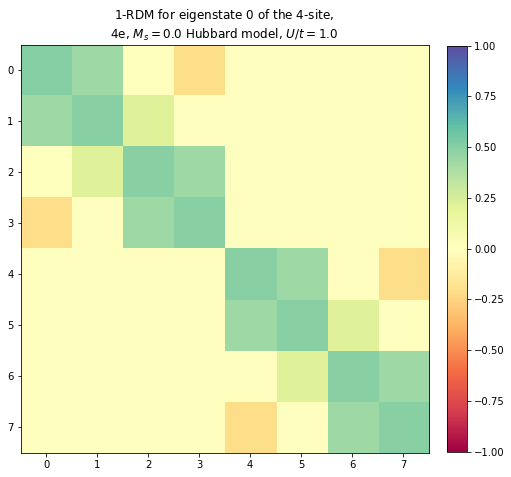

In [4]:
hl = HubbardLattice(4, 2, 2, 1, 1, pbc=False)
hl.solve_model()
hl.plot_rdm(0)

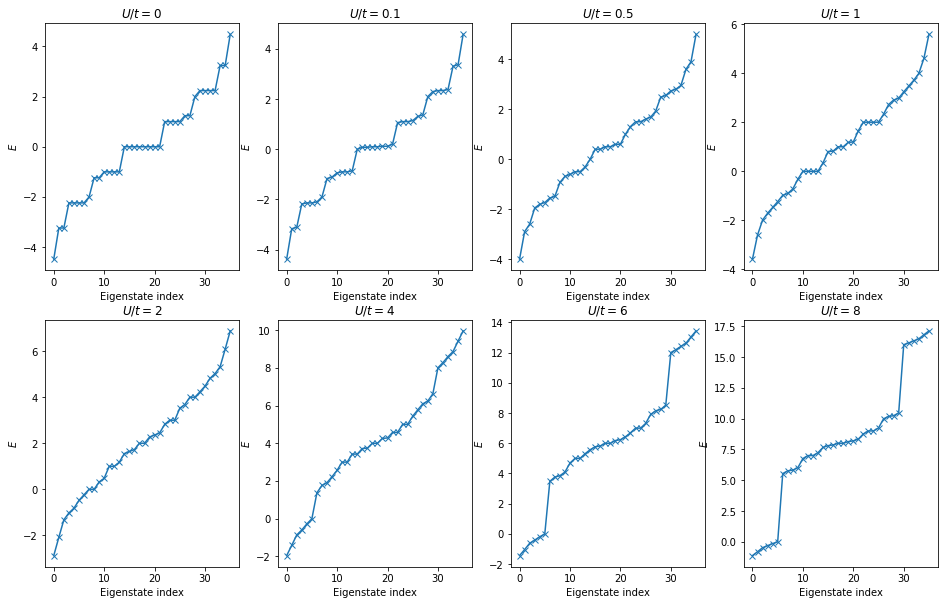

In [5]:
f,axes = plt.subplots(2,4,figsize=(16,10))

for i,u in enumerate([0,0.1,0.5,1,2,4,6,8]):
    hl = HubbardLattice(4, 2, 2, 1, u)
    hl.solve_model()
    axes.flatten()[i].plot(hl.eigvals,marker='x')
    axes.flatten()[i].set_title(r'$U/t={u}$'.format(u=u))
    axes.flatten()[i].set_xlabel('Eigenstate index')
    axes.flatten()[i].set_ylabel(r'$E$')

(-0.4, 0.1)

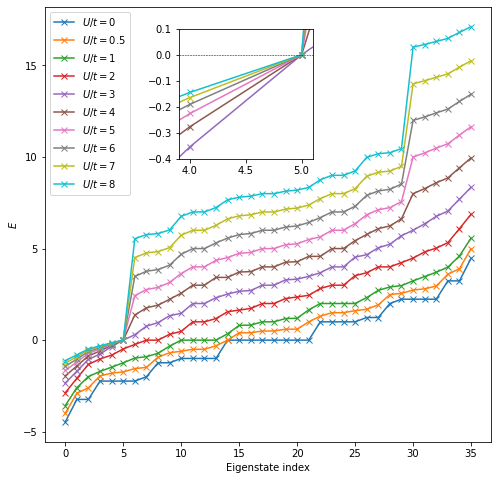

In [202]:
f,ax = plt.subplots(figsize=(8,8))
axins = ax.inset_axes([0.3,0.65,0.3,0.3])

for u in [0,0.5,1,2,3,4,5,6,7,8]:
    hl = HubbardLattice(4, 2, 2, 1, u)
    hl.solve_model()
    ax.plot(hl.eigvals,marker='x',label=r'$U/t={u}$'.format(u=u))
    axins.plot(hl.eigvals,marker='x')

ax.legend()
ax.set_xlabel('Eigenstate index')
ax.set_ylabel(r'$E$')
axins.axhline(y=0.0,c='k',ls='--',lw=0.5)
axins.set_xlim([3.9,5.1])
axins.set_ylim([-0.4,0.1])

(-0.3, 0.1)

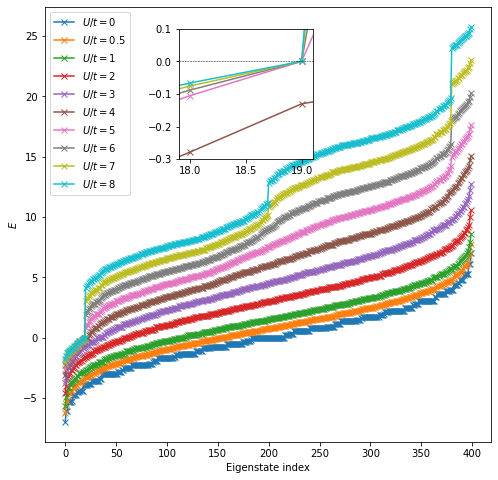

In [108]:
f,ax = plt.subplots(figsize=(8,8))
axins = ax.inset_axes([0.3,0.65,0.3,0.3])

for u in [0,0.5,1,2,3,4,5,6,7,8]:
    hl = HubbardLattice(6, 3, 3, 1, u)
    hl.solve_model()
    ax.plot(hl.eigvals,marker='x',label=r'$U/t={u}$'.format(u=u))
    axins.plot(hl.eigvals,marker='x')

ax.legend()
ax.set_xlabel('Eigenstate index')
ax.set_ylabel(r'$E$')
axins.axhline(y=0.0,c='k',ls='--',lw=0.5)
axins.set_xlim([17.9,19.1])
axins.set_ylim([-0.3,0.1])

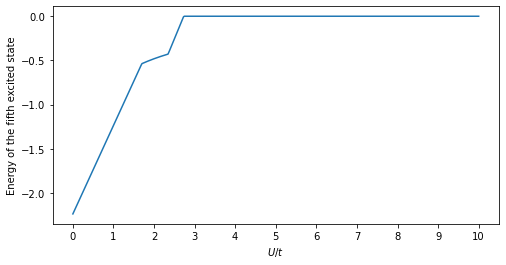

In [109]:
upoints = np.linspace(0,10,500)
e6 = np.zeros(len(upoints))
for i, u in enumerate(upoints):
    hl = HubbardLattice(4, 2, 2, 1, u)
    hl.solve_model()
    e6[i] = hl.eigvals[5]
    
f,ax = plt.subplots(figsize=(8,4))
ax.plot(upoints,e6)
ax.set_xlabel(r'$U/t$')
ax.set_xticks(np.arange(0,11))
_ = ax.set_ylabel('Energy of the fifth excited state')

In [114]:
"""
e19 = np.zeros(len(upoints))
for i, u in enumerate(upoints):
    hl = HubbardLattice(6, 3, 3, 1, u)
    hl.solve_model()
    e19[i] = hl.eigvals[19]
np.save('633-hubbard-19th',e19)
"""

"\ne19 = np.zeros(len(upoints))\nfor i, u in enumerate(upoints):\n    hl = HubbardLattice1D(6, 3, 3, 1, u)\n    hl.solve_model()\n    e19[i] = hl.eigvals[19]\nnp.save('633-hubbard-19th',e19)\n"

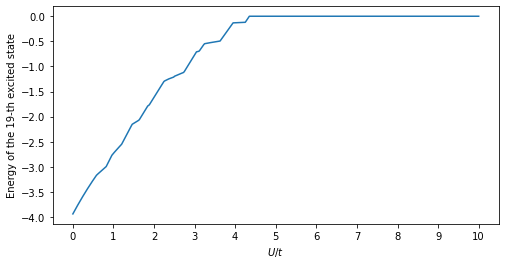

In [115]:
upoints = np.linspace(0,10,500)
e19 = np.load('633-hubbard-19th.npy')
f,ax = plt.subplots(figsize=(8,4))
ax.plot(upoints,e6)
ax.set_xlabel(r'$U/t$')
ax.set_xticks(np.arange(0,11))
_ = ax.set_ylabel('Energy of the 19-th excited state')

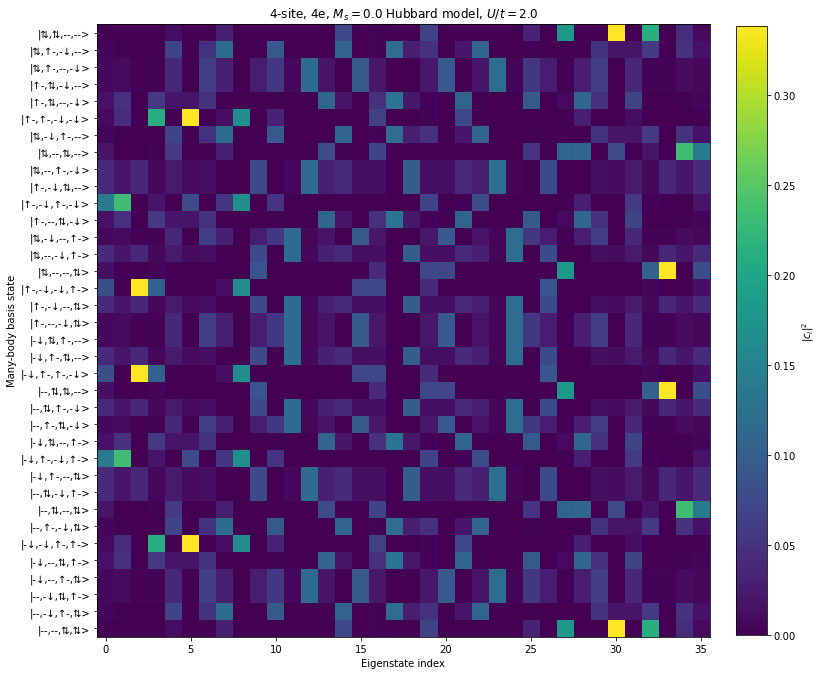

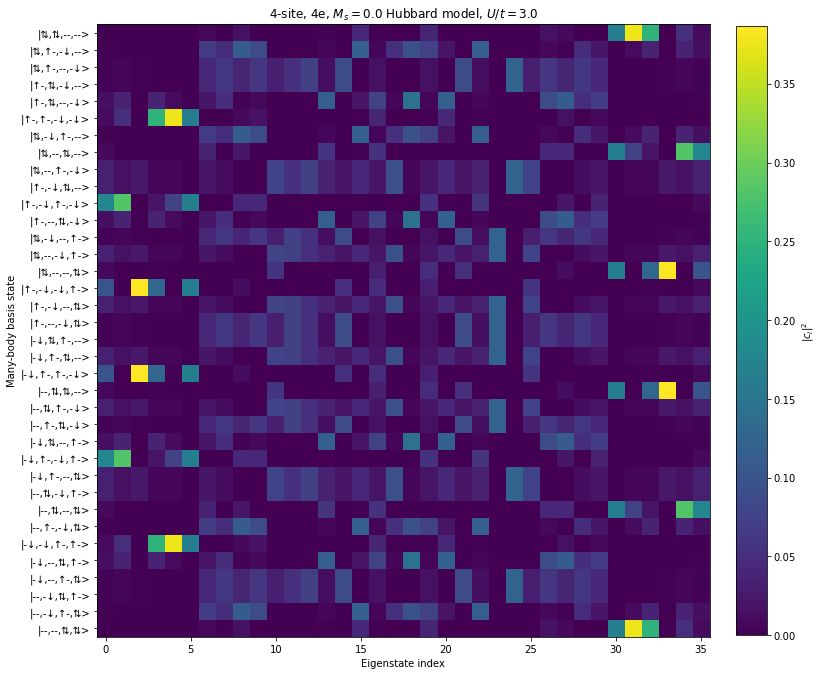

In [120]:
hl = HubbardLattice(4,2,2,t=1,u=2,pbc=False)
hl.solve_model()
hl.plot_eigvecs()
#hl.plot_states()
hl = HubbardLattice(4,2,2,t=1,u=3,pbc=False)
hl.solve_model()
hl.plot_eigvecs()
#hl.plot_states()


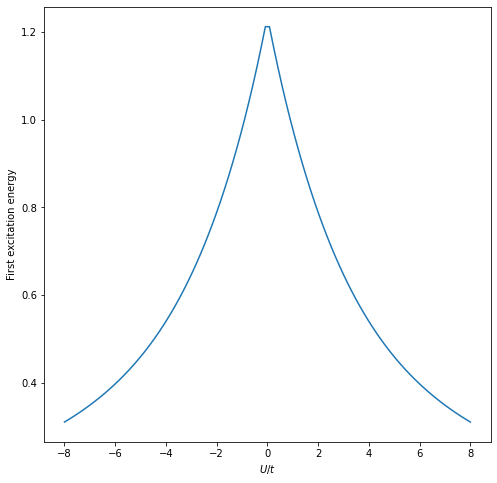

In [121]:
us = np.linspace(-8,8,100)
gap = np.zeros(len(us))

for i, u in enumerate(us):
    hl = HubbardLattice(4, 2, 2, 1, u)
    hl.solve_model()
    gap[i] = hl.eigvals[1] - hl.eigvals[0]

f,ax = plt.subplots(figsize=(8,8))
ax.plot(us,gap)
ax.set_ylabel('First excitation energy')
_ = ax.set_xlabel(r'$U/t$')

<ipython-input-122-d74916ffca82>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  states[:,i] = weights.astype('float64')


Text(0, 0.5, 'Basis state index')

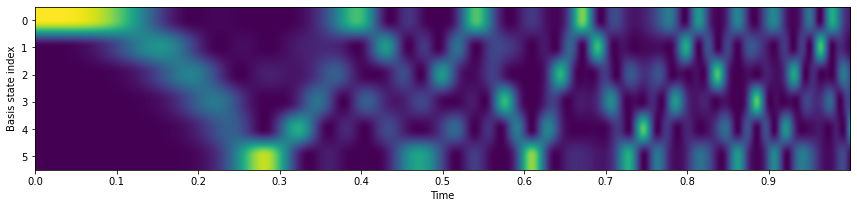

In [122]:
hl = HubbardLattice(6,1,0,t=0.1,u=1,pbc=False)
hl.solve_model()
psi = np.zeros(hl.ncomb)
psi[0] = 1
npoints = 1000

timepoints = np.linspace(0,1,npoints)
states = np.zeros((6,npoints))
for i, t in enumerate(timepoints):
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.conjugate(psi)*psi
    states[:,i] = weights.astype('float64')
    
length = 15
height = 3
    
f, ax = plt.subplots(figsize=(length,height))
ax.imshow(states,aspect=float(npoints/6)*height/length)
xticks = np.arange(0,npoints,int(npoints/10))
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(timepoints[xticks],2))
ax.set_xlabel('Time')
ax.set_ylabel('Basis state index')

<ipython-input-123-9def5fd20f5e>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  states[:,i] = weights.astype('float64')


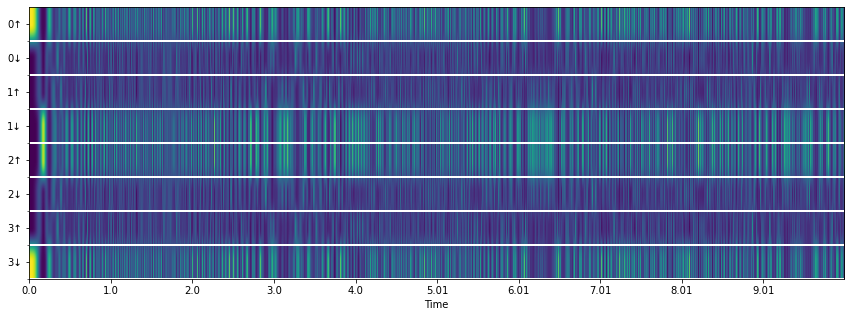

In [123]:
hl = HubbardLattice(4,1,1,t=1,u=1,pbc=True)
hl.solve_model()
psi = np.zeros(hl.ncomb)
psi[3] = 1
npoints = 1000

timepoints = np.linspace(0,10,npoints)
states = np.zeros((hl.bit_string_length,npoints))
for i, t in enumerate(timepoints):
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.dot((np.conjugate(psi)*psi), hl.occ_mat)
    states[:,i] = weights.astype('float64')
    
length = 15
height = 5
    
f, ax = plt.subplots(figsize=(length,height))
ax.imshow(states,aspect=float(npoints/hl.bit_string_length)*height/length)
xticks = np.arange(0,npoints,int(npoints/10))
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(timepoints[xticks],2))
ax.set_xlabel('Time')
ax.set_yticks(np.arange(hl.bit_string_length))
ax.set_yticklabels(['0↑','0↓','1↑','1↓','2↑','2↓','3↑','3↓',])
ax.set_yticks(np.arange(.5, hl.bit_string_length, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

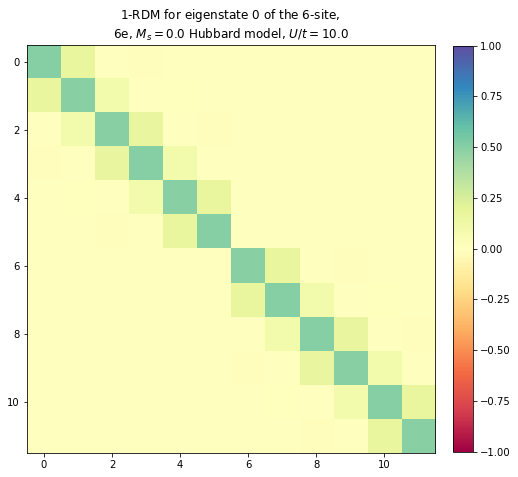

In [153]:
hl = HubbardLattice(6,3,3,t=1,u=10,pbc=False)
hl.solve_model()
hl.plot_rdm(0)

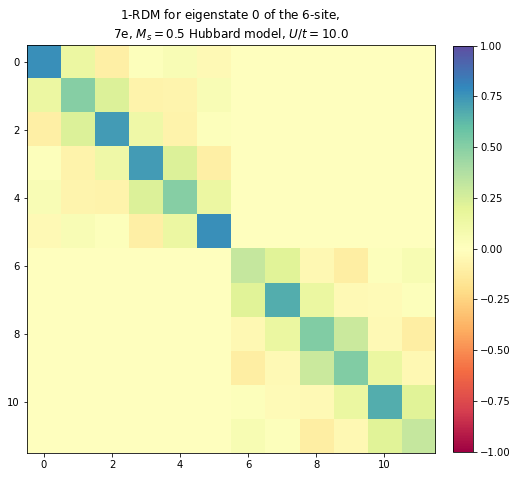

In [154]:
hl = HubbardLattice(6,4,3,t=1,u=10,pbc=False)
hl.solve_model()
hl.plot_rdm(0)

## Testing ground below

In [82]:
hl = HubbardLattice(6,2,0,t=1,u=1)
hl.solve_model()
hl.pretty_print_states()

There are 15 states with 2 alpha electrons and 0 beta electrons in 6 sites.
0    |↑-,↑-,--,--,--,-->
1    |↑-,--,↑-,--,--,-->
2    |↑-,--,--,↑-,--,-->
3    |↑-,--,--,--,↑-,-->
4    |↑-,--,--,--,--,↑->
5    |--,↑-,↑-,--,--,-->
6    |--,↑-,--,↑-,--,-->
7    |--,↑-,--,--,↑-,-->
8    |--,↑-,--,--,--,↑->
9    |--,--,↑-,↑-,--,-->
10   |--,--,↑-,--,↑-,-->
11   |--,--,↑-,--,--,↑->
12   |--,--,--,↑-,↑-,-->
13   |--,--,--,↑-,--,↑->
14   |--,--,--,--,↑-,↑->


In [83]:
for i in hl.tot_strings:
    print(bin(i))

0b11
0b101
0b1001
0b10001
0b100001
0b110
0b1010
0b10010
0b100010
0b1100
0b10100
0b100100
0b11000
0b101000
0b110000


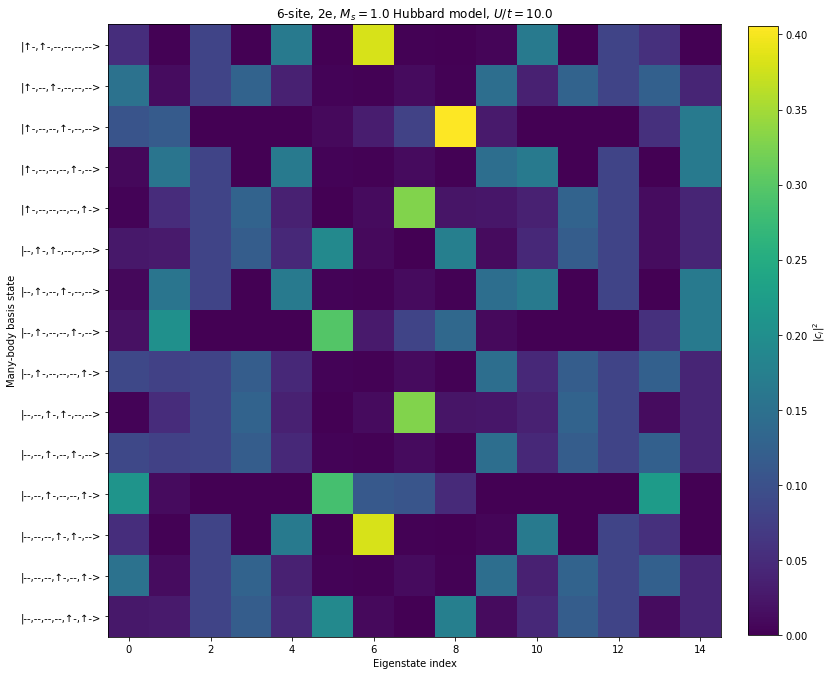

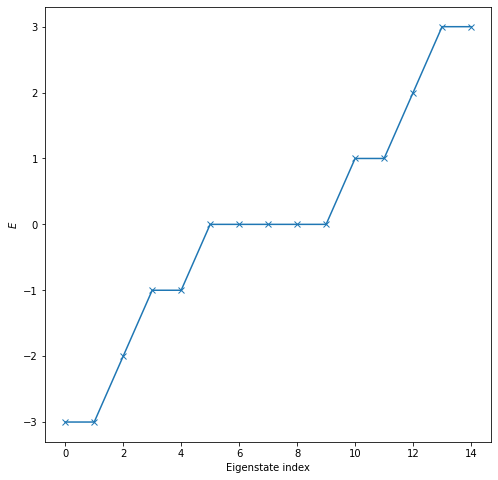

In [4]:
hl = HubbardLattice(6,2,0,t=1,u=10,pbc=True)
hl.solve_model()
hl.plot_eigvecs()
hl.plot_states()

First order reduced density matrix:
$$
\gamma_1(s_1,s_1')=N\int\Psi(s_1,s_2,\dots,s_N)\Psi(s_1',s_2,\dots,s_N)\mathrm{d}s_2\dots\mathrm{d}s_N
$$

In our discrete case,
$$
\gamma_1(s_1,s_1') = N\sum_{\{s_j\neq1\}}\Psi(s_1,s_2,\dots,s_N)\Psi^*(s_1',s_2,\dots,s_N)
$$

In [ ]:
rdm = np.zeros(hl.bit_string_length,hl.bit_string_length)
for isite in range(hl.bit_):
    for jsite in range(hl.bit_string_length):
        

In [20]:
def plot_scatter(t):
    psi = np.zeros(hl.ncomb)
    psi[0] = 1
    f, ax = plt.subplots(figsize=(8,2))
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.conjugate(psi)*psi
    weights = weights.astype('float64')

    ax.bar(np.arange(hl.ncomb),weights)
    ax.set_title(r't={t:.2f}'.format(t=t))
    ax.set_ylim([0,1])

In [21]:
interact(plot_scatter, t=(0,20,0.01))

interactive(children=(FloatSlider(value=10.0, description='t', max=20.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_scatter(t)>

In [3]:
hl = HubbardLattice(4,1,1,t=1,u=1)
hl.solve_model()
hl.pretty_print_states()

There are 16 states with 1 alpha electrons and 1 beta electrons in 4 sites.
0    |⇅,--,--,-->
1    |↑-,-↓,--,-->
2    |↑-,--,-↓,-->
3    |↑-,--,--,-↓>
4    |-↓,↑-,--,-->
5    |--,⇅,--,-->
6    |--,↑-,-↓,-->
7    |--,↑-,--,-↓>
8    |-↓,--,↑-,-->
9    |--,-↓,↑-,-->
10   |--,--,⇅,-->
11   |--,--,↑-,-↓>
12   |-↓,--,--,↑->
13   |--,-↓,--,↑->
14   |--,--,-↓,↑->
15   |--,--,--,⇅>


In [37]:
def plot_scatter(t):
    psi = np.zeros(hl.ncomb)
    psi[3] = 1
    f, ax = plt.subplots(figsize=(8,2))
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.dot((np.conjugate(psi)*psi), hl.occ_mat)
    weights = weights.astype('float64')

    ax.bar(np.arange(hl.bit_string_length),weights)
    ax.set_title(r't={t:.2f}'.format(t=t))
    ax.set_ylim([0,1])

In [38]:
interact(plot_scatter, t=(0,20,0.01))

interactive(children=(FloatSlider(value=10.0, description='t', max=20.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_scatter(t)>

In [18]:
hl.pretty_print_states()
hl.occ_mat

There are 16 states with 1 alpha electrons and 1 beta electrons in 4 sites.
0    |⇅,--,--,-->
1    |↑-,-↓,--,-->
2    |↑-,--,-↓,-->
3    |↑-,--,--,-↓>
4    |-↓,↑-,--,-->
5    |--,⇅,--,-->
6    |--,↑-,-↓,-->
7    |--,↑-,--,-↓>
8    |-↓,--,↑-,-->
9    |--,-↓,↑-,-->
10   |--,--,⇅,-->
11   |--,--,↑-,-↓>
12   |-↓,--,--,↑->
13   |--,-↓,--,↑->
14   |--,--,-↓,↑->
15   |--,--,--,⇅>


array([[1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.]])

In [10]:
np.arange(0,100+1,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

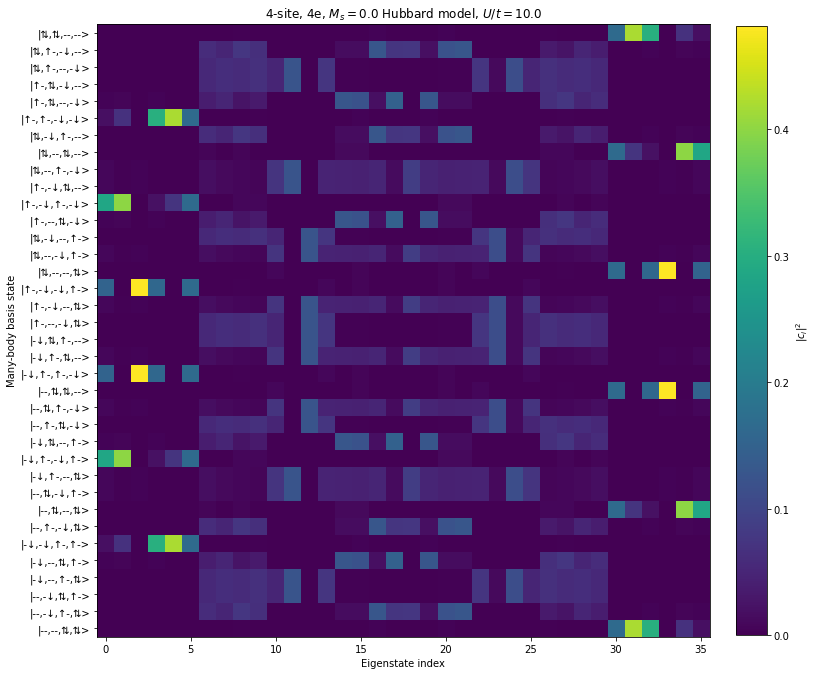

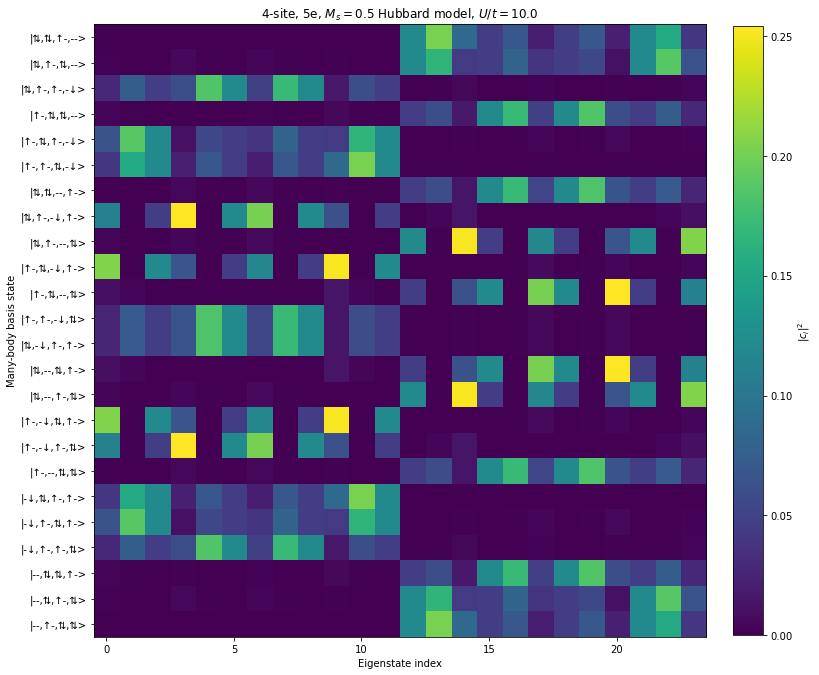

In [9]:
hl = HubbardLattice(4,2,2,t=1,u=10,pbc=False)
hl.solve_model()
hl.plot_eigvecs()
hl = HubbardLattice(4,3,2,t=1,u=10,pbc=False)
hl.solve_model()
hl.plot_eigvecs()

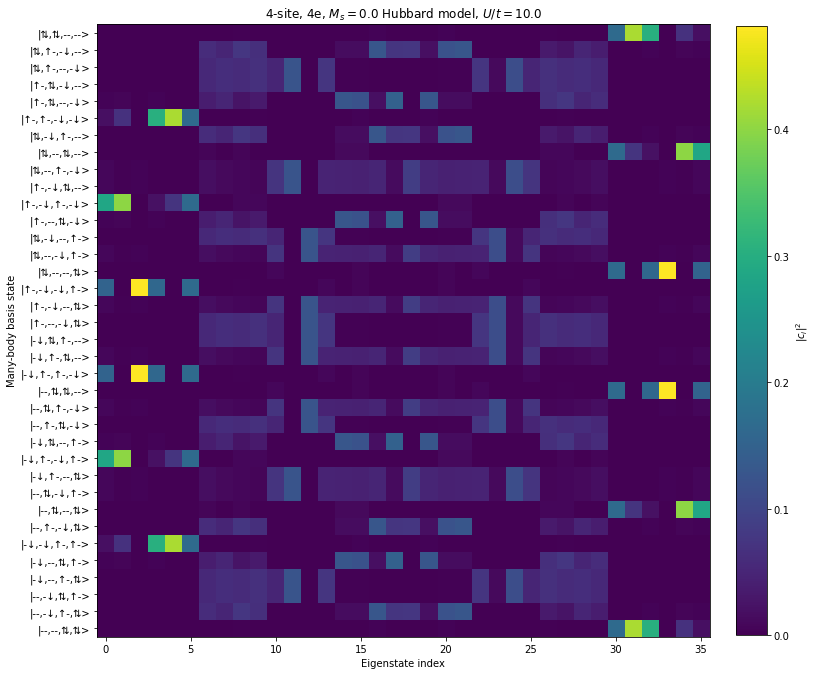

In [91]:
hl = HubbardLattice(4,2,2,t=1,u=10,pbc=False)
hl.solve_model()
hl.plot_eigvecs()

In [160]:
def site_enumeration(lvecs):
    
    try:
        assert (type(lvecs) == type(np.array([0])))
        assert (len(lvecs.shape) == 2)
        assert (lvecs.shape[0] == lvecs.shape[1])
    except AssertionError:
        raise(TypeError('lvecs should be a two-dimensional NumPy array!'))
    
    # Check they're orthogonal
    if (lvecs.shape[0] == 2):
        try:
            assert( np.abs((lvecs[0,:]*lvecs[1,:]).sum()) < 1e-10)
        except AssertionError:
            raise(ValueError('lvecs should contain orthogonal vectors!'))
    
    nsites = 1
    for i in range(lvecs.shape[0]):
        nsites *= np.sqrt(((lvecs[i,:])**2).sum())
    nsites = int(nsites)
    print(nsites)
    
    vertices = np.zeros((4,2))
    vertices[0,:] = [0,0]

    
class HubbardLattice2DRect:
    def __init__(self, x, y, t, u, pbc=False):
        self.xdim = x
        self.ydim = y
        self.t = t
        self.u = u
        self.pbc = pbc
        
        self.site_enumeration_rect()
        self.generate_connections()
        
    def site_enumeration_rect(self):
        self.nsites = self.xdim * self.ydim
        self.sites = np.zeros((self.nsites,2))
        isite = 0
        for i in range(self.xdim):
            for j in range(self.ydim):
                self.sites[isite,:] = [i,j]
                isite += 1

    def generate_connections(self):
        self.connections = np.zeros((self.sites.shape[0], self.sites.shape[0]))
        
        for i, isite in enumerate(self.sites):
            for j, jsite in enumerate(self.sites):
                if (np.abs((((isite-jsite)**2).sum() - 1)) < 1e-10):
                    self.connections[i,j] = 1
                if (self.pbc):
                    dist = np.sqrt(((isite-jsite)**2).sum())
                    if np.abs(dist-(self.xdim-1)) < 1e-10:
                        self.connections[i,j] = 1
                    if np.abs(dist-(self.ydim-1)) < 1e-10:
                        self.connections[i,j] = 1

In [167]:
hl = HubbardLattice2DRect(1,1,1,1,pbc=True)
print(hl.sites)
print(hl.connections)

[[0. 0.]]
[[1.]]


In [112]:
for i in range(1):
    for j in range(1):
        print(i,j)

0 0


In [137]:
hl = HubbardLattice(1,1,0,1,1,pbc=True)
hl.solve_model()
hl.eigvals

array([-2.])

In [134]:
hl.get_excitation_connection(1, 1)

[0, 0]

In [135]:
hl.annop(1, 0)[0] * hl.annop(1, 0)[0]

1

In [26]:
def k_point_enumeration(nsites):
    """
    Okay, to be completely honestly I'm not totally clear on why the boundary conditions are like this, but it works..
    
    From HANDE system.f90::in_FBZ:
        ! This test only works because the underlying lattice is orthogonal.
        ! The asymmetry of the boundary conditions prevent the acceptance of
        ! all wavevectors on the boundaries...
    """
    if type(nsites) is int:
        # 1d
        kmin = 0
        kmax = 0
        while True:
            if ((kmin-1)*1.0/nsites>(-0.5+1e-6)):
                kmin -= 1
            else:
                break
        
        while True:
            if ((kmax+1)*1.0/nsites<=(0.5+1e-6)):
                kmax += 1
            else:
                break
        
        return (kmin,kmax)
    elif type(nsites) is tuple:
        # 2d
        pass
    
def get_k_prod_table(nsites, krange):
    prod_table = np.zeros((nsites,nsites))
    for i in range(nsites):
        for j in range(i+1):
            ksum = (krange[0]+i)+(krange[0]+j)
            if (ksum>krange[1]):
                ksum -= nsites
            if (ksum<krange[0]):
                ksum += nsites
            prod_table[i,j] = prod_table[j,i] = ksum
    
    return prod_table

In [28]:
get_k_prod_table(5,(-2,2))

array([[ 1.,  2., -2., -1.,  0.],
       [ 2., -2., -1.,  0.,  1.],
       [-2., -1.,  0.,  1.,  2.],
       [-1.,  0.,  1.,  2., -2.],
       [ 0.,  1.,  2., -2., -1.]])

In [33]:
hl = HubbardLattice(4,1,0,1,1,pbc=False,kspace=False)

In [45]:
class HubbardLatticeK:
    """
    The k-space Hubbard lattice with periodic boundary conditions in one dimension.
    """
    def __init__(self, nsites, nalpha, nbeta, t, u, verbose=False):
        self.nsites = nsites
        self.ndim = 1
            
        self.bit_string_length = self.nsites*2
        self.nalpha = nalpha
        self.nbeta = nbeta
        self.nel = self.nalpha + self.nbeta
        self.t = t
        self.u = u/self.nsites # This is different from real space!
        self.ms = (nalpha-nbeta)/2.0
        self.verbose = verbose
        
        self.alpha_mask = 0
        self.beta_mask = 0
        for i in range(self.nsites):
            self.alpha_mask = set_bit(self.alpha_mask, i)
            self.beta_mask = set_bit(self.beta_mask, i+self.nsites)
        
        self.nalpha_combinations = None
        self.nbeta_combinations = None
        self.ncomb = None
        self.mem_reqd_list = None
        self.mem_reqd_hamil = None
        self.alpha_strings = None
        self.beta_strings = None
        self.tot_strings = None
        self.hamil = None
        self.eigvals = None
        self.eigvecs = None
        self.occ_mat = None
        self.state_labels = None
        self.sites = None
        self.connections = None
        
        self.k_point_enumeration()
        self.get_k_prod_table()
        
    def k_point_enumeration(self):
        """
        Okay, to be completely honest here, I'm not totally clear on why the boundary conditions are like this, but it works..

        From HANDE system.f90::in_FBZ:
            ! This test only works because the underlying lattice is orthogonal.
            ! The asymmetry of the boundary conditions prevent the acceptance of
            ! all wavevectors on the boundaries...
        """
        kmin = 0
        kmax = 0
        while True:
            if ((kmin-1)*1.0/self.nsites>(-0.5+1e-6)):
                kmin -= 1
            else:
                break

        while True:
            if ((kmax+1)*1.0/self.nsites<=(0.5+1e-6)):
                kmax += 1
            else:
                break
        
        self.kmin = kmin
        self.kmax = kmax
        self.k_sites = list(range(kmin, kmax+1))
        self.k_sites_lookup = {kmin+i:i for i in range(self.nsites)}

    def get_k_prod_table(self):
        self.prod_table = np.zeros((self.nsites,self.nsites))
        for i in range(self.nsites):
            for j in range(i+1):
                ksum = self.k_sites[i] + self.k_sites[j]
                if (ksum > self.kmax):
                    ksum -= self.nsites
                if (ksum < self.kmin):
                    ksum += self.nsites
                self.prod_table[i,j] = self.prod_table[j,i] = ksum #self.k_sites_lookup[ksum]
        
    def creop(self, bit_string, spinorb):
        """
        Creation operator, creates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already occupied, sign is zero and the bit string is returned unchanged.
        """
        # If the bit is set then sgn = 0
        if (test_bit(bit_string, spinorb)):
            sgn = 0
        else:
            test_string = 0
            
            # if we have a beta creation operator, we need to 'hide' the alpha string
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = set_bit(bit_string, spinorb)
            if (spinorb >= self.nsites):
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = set_bit(bit_string, spinorb)

        return (sgn, bit_string)

    def annop(self, bit_string, spinorb):
        """
        Annihilation operator, annihilates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already empty, sign is zero and the bit string is returned unchanged.
        """
        if (not test_bit(bit_string, spinorb)):
            sgn = 0
        else:
            test_string = 0
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = clear_bit(bit_string, spinorb)
            # if we have a beta annihilation operator, we need to 'hide' the alpha string
            else:
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = clear_bit(bit_string, spinorb)
        return (sgn, bit_string)


    def enumerate_states(self):
        """
        Enumerates all states of hl, only conserving Ms symmetry.
        """
        self.nalpha_combinations = int(scipy.special.binom(self.nsites, self.nalpha))
        self.nbeta_combinations = int(scipy.special.binom(self.nsites, self.nbeta))
        self.ncomb = self.nalpha_combinations * self.nbeta_combinations
        self.mem_reqd_list = self.ncomb*8/1e3 # We use 64-bit integers
        self.mem_reqd_hamil = (self.ncomb**2)*8/1e3

        if self.verbose:
            print(f"""There are {self.nalpha_combinations:d} alpha combinations,
{self.nbeta_combinations:d} beta combinations,
making a total of {self.ncomb:d} combinations,
requiring a memory of {self.mem_reqd_list:.2f} kB for the list of states,
and a memory of {self.mem_reqd_hamil:.2f} kB for the Hamiltonian, if requested.""")
        
        self.alpha_strings = np.zeros(self.nalpha_combinations, dtype='int64')
        self.beta_strings = np.zeros(self.nbeta_combinations, dtype='int64')
        self.tot_strings = np.zeros(self.ncomb, dtype='int64')

        comb = list(range(self.nalpha))
        self.alpha_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nalpha_combinations):
            ierr, comb = next_comb(self.nsites, self.nalpha, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.alpha_strings[i] = occ_list_to_bit_string(comb)

        comb = list(range(self.nbeta))
        self.beta_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nbeta_combinations):
            ierr, comb = next_comb(self.nsites, self.nbeta, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.beta_strings[i] = occ_list_to_bit_string(comb)

        istring = 0
        for ialpha in range(self.nalpha_combinations):
            for ibeta in range(self.nbeta_combinations):
                self.tot_strings[istring] = ((self.beta_strings[ibeta])<<self.nsites) | (self.alpha_strings[ialpha])
                istring += 1
        
        self.get_occ_mat()
                
    def bit_string_to_occ_vec(self, bstring):
        ov_alpha = np.zeros(self.nsites, dtype='int32')
        ov_beta = np.zeros(self.nsites, dtype='int32')

        for i in range(self.nsites):
            ov_alpha[i] += (bstring>>i) & 1
            ov_beta[i] += (bstring>>(i+self.nsites)) & 1

        return ov_alpha, ov_beta, (ov_alpha+ov_beta)


    def generate_pretty_state_labels(self):
        if (self.ndim == 1):
            self.state_labels = []
            for bstring in self.tot_strings:
                ov_alpha,ov_beta,_ = self.bit_string_to_occ_vec(bstring)
                string = '|'
                for i in range(self.nsites):
                    if ov_alpha[i] == 0 and ov_beta[i] == 0:
                        string += '--'
                    elif ov_alpha[i] == 1 and ov_beta[i] == 0:
                        string += '↑-'
                    elif ov_alpha[i] == 0 and ov_beta[i] == 1:
                        string += '-↓'
                    elif ov_alpha[i] == 1 and ov_beta[i] == 1:
                        string += '⇅'

                    if i != self.nsites-1:
                        string += ','
                    else:
                        string += '>'
                self.state_labels.append(string)
        
    def get_excitation_connection(self, f1, f2):
        """
        Get the bit location(s) of the set bits, given the number of set bits
        """
        excit_bstring = f1^f2 # 2 bits will be set if single excitation, which is the only type supported for now
        excit = [0,0] # excited from in f1, excited to in f2
        nbit_found = 0
        for i in range(self.bit_string_length):
            if (test_bit(excit_bstring, i)):
                # Check where this electron is coming from / going to
                if (test_bit(f1, i)):
                    excit[0] = i
                else:
                    excit[1] = i
                nbit_found += 1
                if (nbit_found == 2):
                    break
        return excit
                
    def pretty_print_states(self):
        if (self.ndim == 1):
            print(f'There are {self.ncomb:d} states with {self.nalpha:d} alpha electrons and {self.nbeta:d} beta electrons in {self.nsites:d} sites.')
            self.generate_pretty_state_labels()
            for i in range(len(self.tot_strings)):
                print(f'{i:<5d}{self.state_labels[i]}')
            
    def get_hmatel(self, f1, f2):
        """
        <f1|H|f2>
        """
        hmatel = 0.0
        exlvl = get_excitation_level(f1, f2)
        if (exlvl > 1):
            hmatel = 0.0
        else:
            if (exlvl == 0):
                # Diagonal element
                beta_bstring = (f1 >> self.nsites)
                hmatel += self.u * count_set_bits(beta_bstring & f1)
                if (self.pbc):
                    # Possible kinetic contribution
                    if self.ndim == 1 and self.nsites == 1:
                        hmatel -= 2*self.t*self.nel
                    if self.ndim == 2:
                        if self.xdim == 1 and self.ydim == 1:
                            hmatel -= 4*self.t*self.nel
                        elif self.xdim == 1 or self.ydim == 1:
                            hmatel -= 2*self.t*self.nel
            if (exlvl == 1):
                # Off-diagonal element
                excit = self.get_excitation_connection(f1, f2)
                if (self.ndim == 1):
                    if (abs(excit[0]-excit[1]) == 1):
                        sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                        hmatel -= sgn*self.t
                    if (self.pbc and abs(excit[0]-excit[1]) == self.nsites-1):
                        sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                        hmatel -= sgn*self.t
                else:
                    if (self.connections[excit[0]%self.nsites,excit[1]%self.nsites] != 0):
                        sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                        hmatel -= sgn*self.t*self.connections[excit[0]%self.nsites,excit[1]%self.nsites]
                        
        
        return hmatel
    
    def get_hamil(self):
        self.hamil = np.zeros((self.ncomb, self.ncomb))
        
        for i in range(self.ncomb):
            for j in range(i+1):
                self.hamil[i,j] = self.hamil[j,i] = self.get_hmatel(self.tot_strings[i],self.tot_strings[j])
                
    def solve_model(self):
        """
        Just a convenient wrapper
        """
        self.enumerate_states()
        self.get_hamil()
        self.eigvals, self.eigvecs = np.linalg.eigh(self.hamil)
        
    def plot_eigvecs(self):
        if (self.state_labels is None):
            self.generate_pretty_state_labels()
        f,ax = plt.subplots(figsize=(12,12))
        im = ax.imshow((self.eigvecs)**2)
        ax.set_yticks(list(range(self.ncomb)))
        ax.set_yticklabels(self.state_labels)
        f.colorbar(im,fraction=0.0455, pad=0.04, label=r'$|c_i|^2$')
        ax.set_title(r'${nsite}$-site, ${nel}$e, $M_s={ms}$ Hubbard model, $U/t={ut:.1f}$'.format(nsite=self.nsites, nel=self.nel, ms=self.ms, ut=float(self.u/self.t)))
        ax.set_xlabel('Eigenstate index')
        ax.set_ylabel('Many-body basis state')
        
    def get_occ_mat(self):
        # This is essentially doing <psi|n_i|psi>
        self.occ_mat = np.zeros((self.ncomb,self.bit_string_length))
        for i in range(self.ncomb):
            oa, ob, _ = self.bit_string_to_occ_vec(self.tot_strings[i])
            self.occ_mat[i,::2] = oa
            self.occ_mat[i,1::2] = ob
            
    def plot_states(self):
        f,ax = plt.subplots(figsize=(8,8))
        ax.plot(np.arange(self.ncomb),self.eigvals,marker='x')
        ax.set_xlabel('Eigenstate index')
        ax.set_ylabel(r'$E$')
        
    def get_rdm_element(self, i_eigst, i, j):
        rdm_el = 0.0
        for abasis, ca in enumerate(self.eigvecs[:,i_eigst]):
            for bbasis, cb in enumerate(self.eigvecs[:,i_eigst]):
                # ca*cb * <abasis|a_i^ a_j|bbasis>
                isgn,istr = self.annop(self.tot_strings[abasis],i)
                jsgn,jstr = self.annop(self.tot_strings[bbasis],j)
                rdm_el += ca*cb * isgn * jsgn * bstring_dot(istr,jstr)

        return rdm_el

    def get_rdm(self, i_eigst):
        rdm = np.zeros((self.bit_string_length,self.bit_string_length))
        for i in range(self.bit_string_length):
            for j in range(i+1):
                rdm[i,j] = rdm[j,i] = self.get_rdm_element(i_eigst, i, j)

        return rdm
    
    def plot_rdm(self, i_eigst):
        rdm = self.get_rdm(i_eigst)
        f,ax = plt.subplots(figsize=(8,8))
        im = ax.imshow(rdm,vmin=-1,vmax=1,cmap='Spectral')
        f.colorbar(im, fraction=0.0455, pad=0.04)
        ax.set_title(r"""1-RDM for eigenstate {i_eigst} of the ${nsite}$-site, 
${nel}$e, $M_s={ms}$ Hubbard model, $U/t={ut:.1f}$""".format(i_eigst=i_eigst, nsite=self.nsites, nel=self.nel, ms=self.ms, ut=float(self.u/self.t)))
        if (self.ndim == 2):
            ax.set_xticks(list(range(self.bit_string_length)))
            ticklabels = ['('+str(int(_[0]))+','+str(int(_[1]))+')'+'↑' for _ in self.sites]+['('+str(int(_[0]))+','+str(int(_[1]))+')'+'↓' for _ in self.sites]
            ax.set_xticklabels(ticklabels)
            ax.set_yticks(list(range(self.bit_string_length)))
            ax.set_yticklabels(ticklabels)
        
    def site_enumeration_rect(self):
        self.sites = np.zeros((self.nsites,2))
        isite = 0
        for i in range(self.xdim):
            for j in range(self.ydim):
                self.sites[isite,:] = [i,j]
                isite += 1

    def generate_connections(self):
        self.connections = np.zeros((self.nsites, self.nsites))
        
        for i, isite in enumerate(self.sites):
            for j, jsite in enumerate(self.sites):
                if (np.abs((((isite-jsite)**2).sum() - 1)) < 1e-10):
                    self.connections[i,j] = 1
                if (self.pbc):
                    dist = np.sqrt(((isite-jsite)**2).sum())
                    if np.abs(dist-(self.xdim-1)) < 1e-10:
                        self.connections[i,j] += 1
                    if np.abs(dist-(self.ydim-1)) < 1e-10:
                        self.connections[i,j] += 1
                        
    def assign_momentum_symmetry(self):
        self.k_states = {int(isym):[] for isym in self.k_sites}
        for istate in self.tot_strings:
            alpha_string = self.alpha_mask & istate
            beta_string = (self.beta_mask & istate) >> self.nsites
            
            mom = 0 # starts at zero momentum, and just add based on the product table
            for ibit in range(self.nsites):
                if (test_bit(alpha_string, ibit)):
                    mom = self.prod_table[int(mom), int(self.k_sites[ibit])]
                if (test_bit(beta_string, ibit)):
                    mom = self.prod_table[int(mom), int(self.k_sites[ibit])]
                    
            self.k_states[mom].append(istate)

In [46]:
hlk = HubbardLatticeK(4,2,2,1,1)
hlk.enumerate_states()
hlk.assign_momentum_symmetry()

In [47]:
hlk.k_states

{-1: [83, 53, 197, 169, 166, 154, 106, 92],
 0: [147, 99, 85, 57, 201, 54, 198, 170, 156, 108],
 1: [163, 149, 101, 89, 86, 58, 202, 172],
 2: [51, 195, 165, 153, 105, 150, 102, 90, 60, 204]}

In [18]:
hlk.k_sites

[-1, 0, 1, 2]

In [47]:
hlk.k_sites_lookup

{-1: 0, 0: 1, 1: 2, 2: 3}

In [19]:
a = [2,3]
a.append(3)
print(a)

[2, 3, 3]
